In [27]:
import os
import os.path
import requests
import zipfile
import logging
import torch

import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset
from typing import Optional, List, Dict, Tuple
from collections import Counter
from rectools import Columns
from rectools.dataset import Dataset as RTDataset
from rectools.metrics import calc_metrics, NDCG, MAP, MeanInvUserFreq
from rectools.models import model_from_config

import warnings
warnings.filterwarnings("ignore")

In [2]:
logging.basicConfig(
    filename='training.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [3]:
K_RECOS = 10
RANDOM_STATE = 49
NUM_THREADS = 0
map10 = MAP(k=K_RECOS)

# Чтение данных

In [4]:
# data_path = os.environ.get("DATA_PATH")

# def download_and_extract():
#     url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
#     filename = 'kion_train.zip'

#     response = requests.get(url, stream=True)
#     with open(filename, 'wb') as f:
#         total = int(response.headers.get('content-length', 0))
#         progress = tqdm(response.iter_content(1024 * 1024),
#                         f"Downloading {filename}",
#                         total=total // (1024 * 1024), unit='MB')
#         for chunk in progress:
#             f.write(chunk)

#     with zipfile.ZipFile(filename, 'r') as zip_ref:
#         zip_ref.extractall("../../data")
#     os.remove(filename)

# download_and_extract()

In [5]:
data_path = os.environ.get("DATA_PATH")

if data_path is None:
    data_path = "../../data/data_original"  # ваш путь к данным до папки data_original включительно

interactions_df = (
    pd.read_csv(os.path.join(data_path, "interactions.csv"), parse_dates=["last_watch_dt"])
    .rename(columns={'last_watch_dt': Columns.Datetime, 'watched_pct': Columns.Weight})
)
users_df = pd.read_csv(os.path.join(data_path, "users.csv"))
items_df = pd.read_csv(os.path.join(data_path, "items.csv"))

## Тренировочная и тестовая выборки

In [6]:
N_DAYS = 7

max_date = interactions_df['datetime'].max()
train_interactions = interactions_df[(interactions_df['datetime'] <= max_date - pd.Timedelta(days=N_DAYS))]
test_interactions = interactions_df[(interactions_df['datetime'] > max_date - pd.Timedelta(days=N_DAYS))]

cold_users = set(test_interactions[Columns.User].unique()) - set(train_interactions[Columns.User])

test_interactions = test_interactions[~test_interactions[Columns.User].isin(cold_users)]
hot_users = test_interactions[Columns.User].unique()

rt_dataset = RTDataset.construct(test_interactions)

# Обработка данных

## Фильтрация
- Если не фильтровать пользователей и фильмы по количеству взаимодействий, то lightfm работает намного лучше

In [7]:
print(f"N users before: {train_interactions.user_id.nunique()}")
print(f"N items before: {train_interactions.item_id.nunique()}\n")

train_interactions = train_interactions.dropna(subset='weight')

# соберем всех пользователей, которые посмотрели
# больше 5 фильмов (можете выбрать другой порог)
valid_users = []

c = Counter(train_interactions.user_id)
for user_id, entries in c.most_common():
    if entries > 5:
        valid_users.append(user_id)

# и соберем все фильмы, которые посмотрели больше 10 пользователей
valid_items = []

c = Counter(train_interactions.item_id)
for item_id, entries in c.most_common():
    if entries > 10:
        valid_items.append(item_id)

# отбросим непопулярные фильмы и неактивных юзеров
train_interactions = train_interactions[
    (train_interactions.user_id.isin(valid_users))
    & (train_interactions.item_id.isin(valid_items))
    | (train_interactions.user_id.isin(hot_users))
]

users_df = users_df[users_df.user_id.isin(train_interactions.user_id.unique())]
train_interactions = train_interactions[train_interactions.user_id.isin(users_df.user_id.unique())]
items_df = items_df[items_df.item_id.isin(train_interactions.item_id.unique())]

print(f"N users after: {train_interactions.user_id.nunique()}")
print(f"N items after: {train_interactions.item_id.nunique()}")

N users before: 906071
N items before: 15577

N users after: 231872
N items after: 12029


## Кодирование категориальных признаков

In [8]:
# your code here
user_cat_feats = ["age", "income", "sex", "kids_flg"]
# из исходного датафрейма оставим только item_id - этот признак нам понадобится позже
# для того, чтобы маппить айтемы из датафрейма с фильмами с айтемами
# из датафрейма с взаимодействиями
users_ohe_df = users_df.user_id
for feat in user_cat_feats:
    # получаем датафрейм с one-hot encoding для каждой категориальной фичи
    ohe_feat_df = pd.get_dummies(users_df[feat], prefix=feat)
    # конкатенируем ohe-hot датафрейм с датафреймом,
    # который мы получили на предыдущем шаге
    users_ohe_df = pd.concat([users_ohe_df, ohe_feat_df], axis=1)

users_ohe_df.head()

,user_id,age_age_18_24,age_age_25_34,age_age_35_44,age_age_45_54,age_age_55_64,age_age_65_inf,income_income_0_20,income_income_150_inf,income_income_20_40,income_income_40_60,income_income_60_90,income_income_90_150,sex_Ж,sex_М,kids_flg_0,kids_flg_1
1,962099,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
3,721985,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
4,704055,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0
8,846063,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
9,401219,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0


In [9]:
item_cat_feats = [
    'content_type',
    'for_kids', 'age_rating',
    'studios', 'countries'
]
items_ohe_df = items_df.item_id

for feat in item_cat_feats:
    ohe_feat_df = pd.get_dummies(items_df[feat], prefix=feat)
    items_ohe_df = pd.concat([items_ohe_df, ohe_feat_df], axis=1)

genre_dummies = items_df['genres'].str.get_dummies(sep=',')
genre_dummies.columns = ['genre_' + col for col in genre_dummies.columns]

items_ohe_df = pd.concat(
    [items_ohe_df, genre_dummies], axis=1
)

items_ohe_df.head()

,item_id,content_type_film,content_type_series,for_kids_0.0,for_kids_1.0,age_rating_0.0,age_rating_6.0,age_rating_12.0,age_rating_16.0,age_rating_18.0,...,genre_фантастика,genre_фильмы,genre_фильмы hbo,genre_фитнес,genre_футбол,genre_фэнтези,genre_хочу всё знать,genre_шоу,genre_экранизации,genre_юмор
0,10711,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,10716,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,7868,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,16268,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1468,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Вес

In [10]:
n_bins = 20
train_interactions['weight'] = pd.cut(train_interactions['weight'], bins=n_bins+1, labels=False)

## Тест lightFM

In [69]:
user_features_frames = []
for feature in users_ohe_df.drop('user_id', axis=1).columns:
    feature_frame = users_ohe_df.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features_lfm = pd.concat(user_features_frames)
display(user_features_lfm.head())

item_features_frames = []
for feature in items_ohe_df.drop('item_id', axis=1).columns:
    feature_frame = items_ohe_df.reindex(columns=[Columns.Item, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    item_features_frames.append(feature_frame)
item_features_lfm = pd.concat(item_features_frames)
display(item_features_lfm.head())

,id,value,feature
1,962099,1,age_age_18_24
3,721985,0,age_age_18_24
4,704055,0,age_age_18_24
8,846063,0,age_age_18_24
9,401219,0,age_age_18_24


,id,value,feature
0,10711,1,content_type_film
2,10716,1,content_type_film
3,7868,1,content_type_film
4,16268,1,content_type_film
6,1468,1,content_type_film


In [70]:
dataset_with_features = RTDataset.construct(
    interactions_df=train_interactions,
    user_features_df=user_features_lfm,
    cat_user_features=users_ohe_df.drop('user_id', axis=1).columns.to_list(),
    item_features_df=item_features_lfm,
    cat_item_features=items_ohe_df.drop('item_id', axis=1).columns.to_list(),
)

config = {
    'cls': 'LightFMWrapperModel',
    'model': {
        'no_components': 4,
        'loss': 'warp',
        'random_state': 42
    }
}

model = model_from_config(config)
model.fit(dataset_with_features)

recos = model.recommend(
    users=hot_users,
    dataset=dataset_with_features,
    k=K_RECOS,
    filter_viewed=True,
)

print(map10.calc(recos, test_interactions))

0.05360831868598573


## Маппинг uid и iid

In [11]:
train_interactions["uid"] = train_interactions["user_id"].astype("category")
train_interactions["uid"] = train_interactions["uid"].cat.codes

train_interactions["iid"] = train_interactions["item_id"].astype("category")
train_interactions["iid"] = train_interactions["iid"].cat.codes

print(sorted(train_interactions.iid.unique())[:5])
print(sorted(train_interactions.uid.unique())[:5])
train_interactions.head()

[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]


,user_id,item_id,datetime,total_dur,weight,uid,iid
0,176549,9506,2021-05-11,4250,15,37320,6899
1,699317,1659,2021-05-29,8317,20,147692,1223
3,864613,7638,2021-07-05,14483,20,182889,5544
6,1016458,354,2021-08-14,1672,5,214580,262
7,884009,693,2021-08-04,703,2,186918,513


In [12]:
iid_to_item_id = train_interactions[["iid", "item_id"]].drop_duplicates().set_index("iid").to_dict()["item_id"]
item_id_to_iid = train_interactions[["iid", "item_id"]].drop_duplicates().set_index("item_id").to_dict()["iid"]

uid_to_user_id = train_interactions[["uid", "user_id"]].drop_duplicates().set_index("uid").to_dict()["user_id"]
user_id_to_uid = train_interactions[["uid", "user_id"]].drop_duplicates().set_index("user_id").to_dict()["uid"]

In [13]:
items_ohe_df["iid"] = items_ohe_df["item_id"].map(item_id_to_iid)
items_ohe_df = items_ohe_df.set_index("iid")

users_ohe_df["uid"] = users_ohe_df["user_id"].map(user_id_to_uid)
users_ohe_df = users_ohe_df.set_index("uid")

# Матрица взаимодействий
- Формируем матрицу user на item, помечаем единичками взаимодейсвия
- Считаем, сколько у каждого пользователя было взаимодействий
- Для каждого пользователя делим его единички на количество его взаимодействий

In [14]:
train_interactions_vec = np.zeros(
    (train_interactions.uid.nunique(), train_interactions.iid.nunique())
)

for user_id, item_id in zip(train_interactions.uid, train_interactions.iid):
    train_interactions_vec[user_id, item_id] += 1

res = train_interactions_vec.sum(axis=1)
for i in range(len(train_interactions_vec)):
    train_interactions_vec[i] /= res[i]

In [15]:
print(train_interactions.item_id.nunique())
print(items_ohe_df.item_id.nunique())
print(train_interactions.user_id.nunique())
print(users_ohe_df.user_id.nunique())

print(set(items_ohe_df.item_id.unique()) - set(train_interactions.item_id.unique()))

12029
12029
231872
231872
set()


# Основные параметры

In [16]:
N_FACTORS = 128

# в датасетах есть столбец user_id/item_id, помним, что он не является фичей для обучения!
ITEM_MODEL_SHAPE = (items_ohe_df.drop(["item_id"], axis=1).shape[1], )
USER_META_MODEL_SHAPE = (users_ohe_df.drop(["user_id"], axis=1).shape[1], )

USER_INTERACTION_MODEL_SHAPE = (train_interactions_vec.shape[1], )

print(f"N_FACTORS: {N_FACTORS}")
print(f"ITEM_MODEL_SHAPE: {ITEM_MODEL_SHAPE}")
print(f"USER_META_MODEL_SHAPE: {USER_META_MODEL_SHAPE}")
print(f"USER_INTERACTION_MODEL_SHAPE: {USER_INTERACTION_MODEL_SHAPE}")

N_FACTORS: 128
ITEM_MODEL_SHAPE: (835,)
USER_META_MODEL_SHAPE: (16,)
USER_INTERACTION_MODEL_SHAPE: (12029,)


# DSSM

## Инициализация модели и датасета

[Про архитектуры](https://chatgpt.com/share/680411a3-b470-8004-99b8-2fbb0ac042f2)

In [ ]:
# Начальная архитектура
class ItemModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS):
        super(ItemModel, self).__init__()
        self.fc1 = nn.Linear(ITEM_MODEL_SHAPE[0], n_factors)
        self.fc2 = nn.Linear(n_factors, n_factors)
        self.fc3 = nn.Linear(n_factors, n_factors)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = x + torch.relu(self.fc2(x)) # residual connection
        x = self.fc3(x)
        return x
    
class UserModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS):
        super(UserModel, self).__init__()
        self.fc1_meta = nn.Linear(USER_META_MODEL_SHAPE[0], n_factors)
        self.fc2_meta = nn.Linear(n_factors, n_factors)
        self.fc1_interaction = nn.Linear(USER_INTERACTION_MODEL_SHAPE[0], n_factors)
        self.fc3 = nn.Linear(n_factors * 2, n_factors)

    def forward(self, meta, interaction):
        meta = torch.relu(self.fc1_meta(meta))
        meta = torch.relu(self.fc2_meta(meta))
        meta = meta + torch.relu(self.fc2_meta(meta)) # residual connection
        interaction = torch.relu(self.fc1_interaction(interaction))
        x = torch.cat([meta, interaction], dim=1)
        x = self.fc3(x)
        return x
    

# Трансформер, BatchNorm1d, dropout
class ItemModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(ItemModel, self).__init__()
        self.fc1 = nn.Linear(ITEM_MODEL_SHAPE[0], n_factors)
        self.bn1 = nn.BatchNorm1d(n_factors)
        self.fc2 = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        # Легкий TransformerEncoderLayer
        self.transformer = nn.TransformerEncoderLayer(
            d_model=n_factors, nhead=2, dim_feedforward=n_factors, batch_first=True, dropout=dropout
        )
        self.fc3 = nn.Linear(n_factors, n_factors)
        self.ln = nn.LayerNorm(n_factors)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        # Добавим фиктивную размерность для transformer (seq_len=1)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)
        x = self.ln(x)
        x = x + torch.relu(self.fc2(x)) # residual connection
        x = self.fc3(x)
        return x


class UserModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(UserModel, self).__init__()
        self.fc1_meta = nn.Linear(USER_META_MODEL_SHAPE[0], n_factors)
        self.bn_meta = nn.BatchNorm1d(n_factors)
        self.fc2_meta = nn.Linear(n_factors, n_factors)
        self.fc1_interaction = nn.Linear(USER_INTERACTION_MODEL_SHAPE[0], n_factors)
        self.bn_inter = nn.BatchNorm1d(n_factors)
        self.dropout = nn.Dropout(dropout)
        # Transformer для мета-признаков пользователя
        self.transformer_meta = nn.TransformerEncoderLayer(
            d_model=n_factors, nhead=2, dim_feedforward=n_factors, batch_first=True, dropout=dropout
        )
        self.fc3 = nn.Linear(n_factors * 2, n_factors)
        self.ln = nn.LayerNorm(n_factors)

    def forward(self, meta, interaction):
        meta = torch.relu(self.bn_meta(self.fc1_meta(meta)))
        meta = self.dropout(meta)
        meta = torch.relu(self.fc2_meta(meta))
        meta = meta.unsqueeze(1)
        meta = self.transformer_meta(meta)
        meta = meta.squeeze(1)
        meta = self.ln(meta)
        meta = meta + torch.relu(self.fc2_meta(meta)) # residual connection
        interaction = torch.relu(self.bn_inter(self.fc1_interaction(interaction)))
        interaction = self.dropout(interaction)
        x = torch.cat([meta, interaction], dim=1)
        x = self.fc3(x)
        return x
    

# Добавил BatchNorm1d, Dropou, убрал TransformerEncoderLayer
class ItemModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(ItemModel, self).__init__()
        self.fc1 = nn.Linear(ITEM_MODEL_SHAPE[0], n_factors)
        self.bn1 = nn.BatchNorm1d(n_factors)
        self.fc2 = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        self.fc3 = nn.Linear(n_factors, n_factors)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = x + torch.relu(self.fc2(x)) # residual connection
        x = self.fc3(x)
        return x


class UserModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(UserModel, self).__init__()
        self.fc1_meta = nn.Linear(USER_META_MODEL_SHAPE[0], n_factors)
        self.bn_meta = nn.BatchNorm1d(n_factors)
        self.fc2_meta = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        self.fc1_interaction = nn.Linear(USER_INTERACTION_MODEL_SHAPE[0], n_factors)
        self.bn_inter = nn.BatchNorm1d(n_factors)
        self.fc2_inter = nn.Linear(n_factors, n_factors)
        self.fc3 = nn.Linear(n_factors * 2, n_factors)

    def forward(self, meta, interaction):
        meta = torch.relu(self.bn_meta(self.fc1_meta(meta)))
        meta = self.dropout(meta)
        meta = torch.relu(self.fc2_meta(meta))
        meta = meta + torch.relu(self.fc2_meta(meta)) # residual connection
        interaction = torch.relu(self.bn_inter(self.fc1_interaction(interaction)))
        interaction = self.dropout(interaction)
        interaction = torch.relu(self.fc2_inter(interaction))
        x = torch.cat([meta, interaction], dim=1)
        x = self.fc3(x)
        return x
    
# Добавил LayerNorm (лучшая архитектура для tp_loss)
class ItemModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(ItemModel, self).__init__()
        self.fc1 = nn.Linear(ITEM_MODEL_SHAPE[0], n_factors)
        self.ln1 = nn.LayerNorm(n_factors)
        self.fc2 = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        self.fc3 = nn.Linear(n_factors, n_factors)

    def forward(self, x):
        x = torch.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = x + torch.relu(self.fc2(x)) # residual connection
        x = self.fc3(x)
        return x

class UserModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(UserModel, self).__init__()
        self.fc1_meta = nn.Linear(USER_META_MODEL_SHAPE[0], n_factors)
        self.ln_meta = nn.LayerNorm(n_factors)
        self.fc2_meta = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        self.fc1_interaction = nn.Linear(USER_INTERACTION_MODEL_SHAPE[0], n_factors)
        self.ln_inter = nn.LayerNorm(n_factors)
        self.fc2_inter = nn.Linear(n_factors, n_factors)
        self.fc3 = nn.Linear(n_factors * 2, n_factors)

    def forward(self, meta, interaction):
        meta = torch.relu(self.ln_meta(self.fc1_meta(meta)))
        meta = self.dropout(meta)
        meta = torch.relu(self.fc2_meta(meta))
        meta = meta + torch.relu(self.fc2_meta(meta)) # residual connection
        interaction = torch.relu(self.ln_inter(self.fc1_interaction(interaction)))
        interaction = self.dropout(interaction)
        interaction = torch.relu(self.fc2_inter(interaction))
        x = torch.cat([meta, interaction], dim=1)
        x = self.fc3(x)
        return x
    

# Добавил нормализацию для экспериментов с bpr_loss
class ItemModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(ItemModel, self).__init__()
        self.fc1 = nn.Linear(ITEM_MODEL_SHAPE[0], n_factors)
        self.ln1 = nn.LayerNorm(n_factors)
        self.fc2 = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        self.fc3 = nn.Linear(n_factors, n_factors)

    def forward(self, x):
        x = torch.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = x + torch.relu(self.fc2(x)) # residual connection
        x = self.fc3(x)
        x = F.normalize(x, p=2, dim=1)  # L2-нормализация
        return x

class UserModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(UserModel, self).__init__()
        self.fc1_meta = nn.Linear(USER_META_MODEL_SHAPE[0], n_factors)
        self.ln_meta = nn.LayerNorm(n_factors)
        self.fc2_meta = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        self.fc1_interaction = nn.Linear(USER_INTERACTION_MODEL_SHAPE[0], n_factors)
        self.ln_inter = nn.LayerNorm(n_factors)
        self.fc2_inter = nn.Linear(n_factors, n_factors)
        self.fc3 = nn.Linear(n_factors * 2, n_factors)

    def forward(self, meta, interaction):
        meta = torch.relu(self.ln_meta(self.fc1_meta(meta)))
        meta = self.dropout(meta)
        meta = torch.relu(self.fc2_meta(meta))
        meta = meta + torch.relu(self.fc2_meta(meta)) # residual connection
        interaction = torch.relu(self.ln_inter(self.fc1_interaction(interaction)))
        interaction = self.dropout(interaction)
        interaction = torch.relu(self.fc2_inter(interaction))
        x = torch.cat([meta, interaction], dim=1)
        x = self.fc3(x)
        x = F.normalize(x, p=2, dim=1)  # L2-нормализация
        return x

[Про лоссы](https://chatgpt.com/share/68048c0c-2d20-8003-81c7-c4aaa165176d)

In [18]:
# Define the triplet loss function
def triplet_loss(anchor, positive, negative, alpha=0.4):
    pos_dist = torch.sum(torch.square(anchor - positive), dim=1)
    neg_dist = torch.sum(torch.square(anchor - negative), dim=1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = torch.max(basic_loss, torch.zeros_like(basic_loss))
    return loss.mean()

def bpr_loss(anchor, positive, negative):
    sim_ap = torch.nn.functional.cosine_similarity(anchor, positive, dim=1)
    sim_an = torch.nn.functional.cosine_similarity(anchor, negative, dim=1)
    diff = sim_ap - sim_an
    loss = 1 - torch.sigmoid(diff)
    return loss.mean()

In [19]:
class RecSysDataset(Dataset):
    def __init__(self, items, users, interactions, device, num_negs=10):
        self.items = items
        self.users = users
        self.interactions = interactions
        self.device = device
        self.num_negs = num_negs

    def __len__(self):
        return self.interactions.shape[0]

    def __getitem__(self, idx):
        uid = idx
        pos_i = np.random.choice(range(self.interactions.shape[1]), p=self.interactions[uid])
        # Просто случайные негативы (без hard negative mining)
        neg_is = np.random.choice(range(self.interactions.shape[1]), size=self.num_negs, replace=False)
        uid_meta = self.users.iloc[uid].values
        uid_interaction = self.interactions[uid]
        pos = self.items.iloc[pos_i].values
        negs = np.stack([self.items.iloc[neg_i].values for neg_i in neg_is])
        return (
            torch.tensor(uid_meta, dtype=torch.float32).to(self.device),
            torch.tensor(uid_interaction, dtype=torch.float32).to(self.device),
            torch.tensor(pos, dtype=torch.float32).to(self.device),
            torch.tensor(negs, dtype=torch.float32).to(self.device)
        )

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
# Initialize the models, optimizer, and dataset
i2v = ItemModel().to(device)
u2v = UserModel().to(device)
optimizer = optim.Adam(list(i2v.parameters()) + list(u2v.parameters()), lr=0.001)
dataset = RecSysDataset(
    items=items_ohe_df.drop(["item_id"], axis=1),
    users=users_ohe_df.drop(["user_id"], axis=1),
    interactions=train_interactions_vec,
    device=device
)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

## Обучение

In [22]:
# Training loop
torch.cuda.empty_cache()
num_epochs = 5
loss_fn = bpr_loss  # или bpr_loss

for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        uid_meta, uid_interaction, pos, negs = batch
        optimizer.zero_grad()
        anchor = u2v(uid_meta, uid_interaction)  # [batch, emb]
        positive = i2v(pos)                     # [batch, emb]
        batch_size, num_negs, feat_dim = negs.shape
        negative = i2v(negs.view(-1, feat_dim)).view(batch_size, num_negs, -1)  # [batch, num_negs, emb]
        if loss_fn == triplet_loss:
            # Для triplet_loss используем только первый негатив
            loss = loss_fn(anchor, positive, negative[:, 0, :])
        else:
            # Для bpr_loss используем все негативы
            anchor_exp = anchor.unsqueeze(1).expand(-1, num_negs, -1)    # [batch, num_negs, emb]
            positive_exp = positive.unsqueeze(1).expand(-1, num_negs, -1)  # [batch, num_negs, emb]
            sim_ap = torch.nn.functional.cosine_similarity(anchor_exp, positive_exp, dim=2)  # [batch, num_negs]
            sim_an = torch.nn.functional.cosine_similarity(anchor_exp, negative, dim=2)      # [batch, num_negs]
            diff = sim_ap - sim_an
            loss = 1 - torch.sigmoid(diff)
            loss = loss.mean()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch + 1}, Average Epoch Loss: {avg_epoch_loss:.4f}")


Epoch 1: 100%|██████████| 227/227 [08:14<00:00,  2.18s/it]


Epoch 1, Average Epoch Loss: 0.3456


Epoch 2: 100%|██████████| 227/227 [08:11<00:00,  2.17s/it]


Epoch 2, Average Epoch Loss: 0.3191


Epoch 3: 100%|██████████| 227/227 [08:05<00:00,  2.14s/it]


Epoch 3, Average Epoch Loss: 0.3138


Epoch 4: 100%|██████████| 227/227 [08:05<00:00,  2.14s/it]


Epoch 4, Average Epoch Loss: 0.3111


Epoch 5: 100%|██████████| 227/227 [07:59<00:00,  2.11s/it]

Epoch 5, Average Epoch Loss: 0.3082


In [24]:
torch.save(i2v.state_dict(), '../../artifacts/i2v_model_bpr_loss_norm')
torch.save(u2v.state_dict(), '../../artifacts/u2v_model_bpr_loss_norm')

# Инференс

In [25]:
# Загрузка
i2v = ItemModel().to(device)
i2v.load_state_dict(torch.load('../../artifacts/i2v_model_bpr_loss_norm'))
i2v.eval()

u2v = UserModel().to(device)
u2v.load_state_dict(torch.load('../../artifacts/u2v_model_bpr_loss_norm'))
u2v.eval()

UserModel(
  (fc1_meta): Linear(in_features=16, out_features=128, bias=True)
  (ln_meta): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc2_meta): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1_interaction): Linear(in_features=12029, out_features=128, bias=True)
  (ln_inter): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc2_inter): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
)

In [23]:
from typing import Optional, List, Dict
from torch.utils.data import DataLoader, TensorDataset

Metrics on test set (all items):
{'ndcg@10': 0.004268759723329381, 'map@10': 0.007981950890367883, 'novelty@10': 10.359371160120494}
Metrics on test set (only new items):
{'ndcg@10': 0.004424605129663591, 'map@10': 0.00840846146571718, 'novelty@10': 10.507040145281902}
Metrics on train set:
{'ndcg@10': 0.026595616391652716, 'map@10': 0.014998711478326257, 'novelty@10': 10.474641643549294}


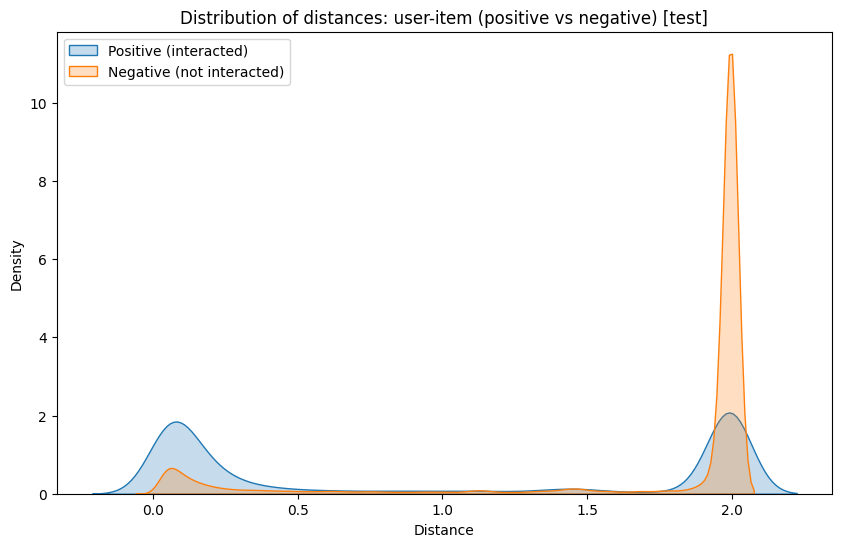

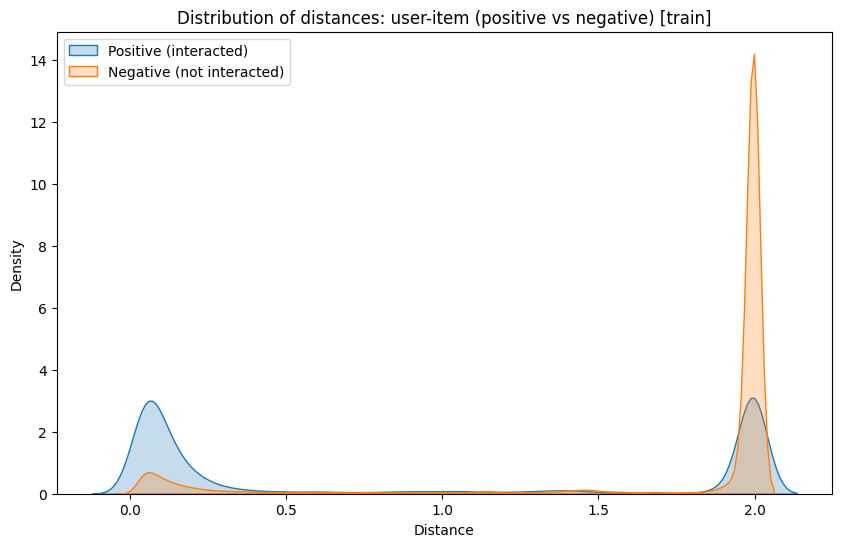

In [28]:
# --- Inference ---
def get_top_k_recommendations(
    u2v,
    users_meta: np.ndarray,
    interactions_vec: np.ndarray,
    items_vecs: torch.Tensor,
    K: int,
    device: torch.device,
    user_indices: Optional[List] = None,
    batch_size: int = 1024,
    filter_viewed: bool = False,
    user2train_items: Optional[Dict] = None,
    iid_to_item_id: Optional[Dict] = None,
    uid_to_user_id: Optional[Dict] = None,
) -> pd.DataFrame:
    """
    Compute top-K recommendations for users. Returns DataFrame with columns: user_id, item_id, rank.
    """
    dataset = TensorDataset(torch.tensor(users_meta, dtype=torch.float32), torch.arange(users_meta.shape[0]))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    recos = []
    with torch.no_grad():
        for batch_users_meta, batch_idx in loader:
            batch_users_meta = batch_users_meta.to(device)
            batch_inter_idx = (
                [user_indices[i.item()] for i in batch_idx] if user_indices is not None else batch_idx.tolist()
            )
            batch_users_interaction = torch.tensor(interactions_vec[batch_inter_idx], dtype=torch.float32).to(device)
            batch_users_vec = u2v(batch_users_meta, batch_users_interaction)
            batch_dists = torch.cdist(batch_users_vec, items_vecs)
            batch_dists_np = batch_dists.cpu().numpy()
            if filter_viewed:
                assert user2train_items is not None and iid_to_item_id is not None and uid_to_user_id is not None
                for i, idx in enumerate(batch_idx):
                    uid = user_indices[idx.item()] if user_indices is not None else idx.item()
                    user_id = uid_to_user_id[uid]
                    seen_items = user2train_items.get(user_id, set())
                    n_candidates = K + len(seen_items)
                    reco_iids = np.argsort(batch_dists_np[i])[:n_candidates]
                    reco_item_ids = [iid_to_item_id[iid] for iid in reco_iids]
                    reco_new = [item for item in reco_item_ids if item not in seen_items][:K]
                    for rank, item_id in enumerate(reco_new, 1):
                        recos.append({"user_id": user_id, "item_id": item_id, "rank": rank})
            else:
                batch_topk = np.argsort(batch_dists_np, axis=1)[:, :K]
                for i, idx in enumerate(batch_idx):
                    uid = user_indices[idx.item()] if user_indices is not None else idx.item()
                    user_id = uid_to_user_id[uid]
                    for rank, iid in enumerate(batch_topk[i], 1):
                        item_id = iid_to_item_id[iid]
                        recos.append({"user_id": user_id, "item_id": item_id, "rank": rank})
            del batch_users_meta, batch_users_interaction, batch_users_vec, batch_dists, batch_dists_np
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    return pd.DataFrame(recos)

def build_recs_df(topk_iids, uid_list, uid_to_user_id, iid_to_item_id):
    topk_iids_item = [iid_to_item_id[iid.item()] for iid in topk_iids.reshape(-1)]
    topk_iids_item = np.array(topk_iids_item).reshape(topk_iids.shape)
    df = pd.DataFrame({'user_id': [uid_to_user_id[uid] for uid in uid_list]})
    df['item_id'] = list(topk_iids_item)
    df = df.explode('item_id')
    df['rank'] = df.groupby('user_id').cumcount() + 1
    return df

# --- Plotting ---
def plot_distance_distributions(
    u2v,
    users_meta: np.ndarray,
    interactions_vec: np.ndarray,
    items_vecs: torch.Tensor,
    user2items_ids: Dict,
    all_item_ids: np.ndarray,
    device: torch.device,
    user_indices: List,
    desc: str,
    batch_size: int = 512,
):
    """
    Plot KDE of distances for positive (interacted) and negative (not interacted) user-item pairs.
    """
    pos_distances, neg_distances = [], []
    uids = list(user2items_ids.keys())
    uid_to_meta_idx = {uid: idx for idx, uid in enumerate(uids)}
    meta_indices = [uid_to_meta_idx[uid] for uid in uids]
    users_meta_batch = users_meta[meta_indices]
    users_inter_idx = [user_indices[idx] for idx in meta_indices]
    users_inter_batch = interactions_vec[users_inter_idx]
    dataset = TensorDataset(
        torch.tensor(users_meta_batch, dtype=torch.float32), torch.tensor(users_inter_batch, dtype=torch.float32)
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    user_ptr = 0
    with torch.no_grad():
        for batch_users_meta, batch_users_interaction in loader:
            batch_users_meta = batch_users_meta.to(device)
            batch_users_interaction = batch_users_interaction.to(device)
            batch_users_vec = u2v(batch_users_meta, batch_users_interaction).cpu()
            for i in range(batch_users_vec.shape[0]):
                uid = uids[user_ptr]
                user_vec = batch_users_vec[i].unsqueeze(0)
                pos_iids = list(user2items_ids[uid])
                if pos_iids:
                    pos_item_vecs = items_vecs[pos_iids].detach().cpu()
                    dists = torch.norm(user_vec - pos_item_vecs, dim=1).numpy()
                    pos_distances.extend(dists.tolist())
                neg_iids = list(set(all_item_ids) - set(pos_iids))
                if neg_iids:
                    neg_sample = np.random.choice(neg_iids, size=min(100, len(neg_iids)), replace=False)
                    neg_item_vecs = items_vecs[neg_sample].detach().cpu()
                    dists = torch.norm(user_vec - neg_item_vecs, dim=1).numpy()
                    neg_distances.extend(dists.tolist())
                user_ptr += 1
            del batch_users_meta, batch_users_interaction, batch_users_vec
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    plt.figure(figsize=(10, 6))
    sns.kdeplot(pos_distances, label="Positive (interacted)", fill=True)
    sns.kdeplot(neg_distances, label="Negative (not interacted)", fill=True)
    plt.xlabel("Distance")
    plt.ylabel("Density")
    plt.title(f"Distribution of distances: user-item (positive vs negative) [{desc}]")
    plt.legend()
    plt.show()

# --- Data Preparation ---
def get_users_meta_and_indices(users, users_ohe_df: pd.DataFrame) -> Tuple[List, np.ndarray]:
    """Return sorted user list and their meta features array."""
    users = sorted(users)
    users_meta = users_ohe_df.loc[users].drop(["user_id"], axis=1).values
    return users, users_meta


def calc_metrics_(recos, interactions) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k=K_RECOS),
        'map@10': MAP(k=K_RECOS),
        'novelty@10': MeanInvUserFreq(k = K_RECOS),
    }
    return calc_metrics(
        metrics=metrics,
        reco=recos,
        interactions=interactions,
        prev_interactions=train_interactions,
        catalog=train_interactions.item_id.unique()
    )

# Подготовка данных
test_interactions_filtered = test_interactions[
    test_interactions.user_id.isin(train_interactions.user_id.unique())
    & test_interactions.item_id.isin(train_interactions.item_id.unique())
]

test_interactions_filtered["uid"] = test_interactions_filtered["user_id"].map(user_id_to_uid)
test_interactions_filtered["iid"] = test_interactions_filtered["item_id"].map(item_id_to_iid)

items_feats = torch.tensor(items_ohe_df.drop(["item_id"], axis=1).values, dtype=torch.float32).to(device)
items_vecs = i2v(items_feats)


# Inference: test set (all items)
test_users, test_users_meta = get_users_meta_and_indices(test_interactions_filtered.uid.unique(), users_ohe_df)
df_dssm_test = get_top_k_recommendations(
    u2v,
    test_users_meta,
    train_interactions_vec,
    items_vecs,
    K_RECOS,
    device,
    user_indices=test_users,
    filter_viewed=False,
    iid_to_item_id=iid_to_item_id,
    uid_to_user_id=uid_to_user_id,
)
print('Metrics on test set (all items):')
print(calc_metrics_(df_dssm_test, test_interactions_filtered))

# Inference: test set (only new items)
user2train_items = train_interactions.groupby("user_id")["item_id"].apply(set).to_dict()
df_dssm_test_new = get_top_k_recommendations(
    u2v,
    test_users_meta,
    train_interactions_vec,
    items_vecs,
    K_RECOS,
    device,
    user_indices=test_users,
    filter_viewed=True,
    user2train_items=user2train_items,
    iid_to_item_id=iid_to_item_id,
    uid_to_user_id=uid_to_user_id,
)
print('Metrics on test set (only new items):')
print(calc_metrics_(df_dssm_test_new, test_interactions_filtered))

# Inference: all train users
all_users, all_users_meta = get_users_meta_and_indices(train_interactions.uid.unique(), users_ohe_df)
df_dssm = get_top_k_recommendations(
    u2v,
    all_users_meta,
    train_interactions_vec,
    items_vecs,
    K_RECOS,
    device,
    user_indices=all_users,
    filter_viewed=False,
    iid_to_item_id=iid_to_item_id,
    uid_to_user_id=uid_to_user_id,
)
print('Metrics on train set:')
print(calc_metrics_(df_dssm, train_interactions))


# Plotting: test
test_user2items_ids = test_interactions_filtered.groupby("uid")["iid"].apply(set).to_dict()
all_item_ids = train_interactions.iid.unique()
plot_distance_distributions(
    u2v,
    test_users_meta,
    train_interactions_vec,
    items_vecs,
    test_user2items_ids,
    all_item_ids,
    device,
    user_indices=test_users,
    desc="test",
    batch_size=128,
)
# Plotting: train
train_user2items_ids = train_interactions.groupby("uid")["iid"].apply(set).to_dict()
plot_distance_distributions(
    u2v,
    all_users_meta,
    train_interactions_vec,
    items_vecs,
    train_user2items_ids,
    all_item_ids,
    device,
    user_indices=all_users,
    desc="train",
    batch_size=128,
)

# Итого

- Реализовал обучение и инференс на GPU
- Разбил данные на тестовую и тренировочную метрику
- Реализовал расчет метрик
- Обучил lightfm для сравнения. Заметил, что без фильтрации датасета метрика на тестовой выборке намного лучше
- Эксперименты с архитектурами `UserModel` и `ItemModel`:  
    - Добавлены слои `BatchNorm1d` и `dropout`.
    - Добавлен `TransformerEncoderLayer`. Сначала добавил этот слой для мета данных юзеров и айтемов, потом понял, что его нужно добавлять для вектора взаимодействий. Но после более подробного изучения понял, что вектора взаимодействий должны учитывать временную составляющу, чтобы работал механизм внимания. Задача нетривиальная, принял решение пока отказаться от использования данного слоя
    - Добавлен этап LN, это позволило добиться наилучших результатов
- Реализован инференс с рассчетом `MAP`, `NDCG`, `novelty` и выводом гистограмм распределения расстояний между позитивом и негативом. Инференс для тестовой выборки реализован в 2х вариантах: рекомендуем все item или рекомендуем только новые. Рекомендацию только непросмотренных item позволила улучшить метрику `MAP` и существенно улучшить `novelty`
- Реализован BPR_loss. С этим лоссом не удалось добиться сходимости. Проводились эксперименты с архитектурой, сэмплированием негативных примеров, количеством эпох, learning_rate, размером батча. Ничего из этого не помогло, принято решение остановиться на triplet_loss
- UPD по BPR_loss. После анализа распределения расстояний для позитивов и негативов заметил, что расстояния распределениы примерно от 50 до 255, в то время как для triplet_loss они распределены от 0.5 до 4. Накатило осознание, что нужно попробовать добавить в архитектуру L2 нормализацию для эмбеддингов при использовании bpr_loss.
В итоге это не помогло, но распределение расстояний поменялось. Появился бугор около 0 и бугор около 2х.

Дропауты, триплетт лосс

Metrics on test set (all items):  
{'ndcg@10': 0.020150051921643704, 'map@10': 0.03442064385565833, 'novelty@10': 6.6893864751852234}  
Metrics on test set (only new items):  
{'ndcg@10': 0.022607524303127062, 'map@10': 0.040237918803309895, 'novelty@10': 7.4382998570788175}  
Metrics on train set:  
{'ndcg@10': 0.1528670560518531, 'map@10': 0.08338817995936873, 'novelty@10': 6.150502687035253}  

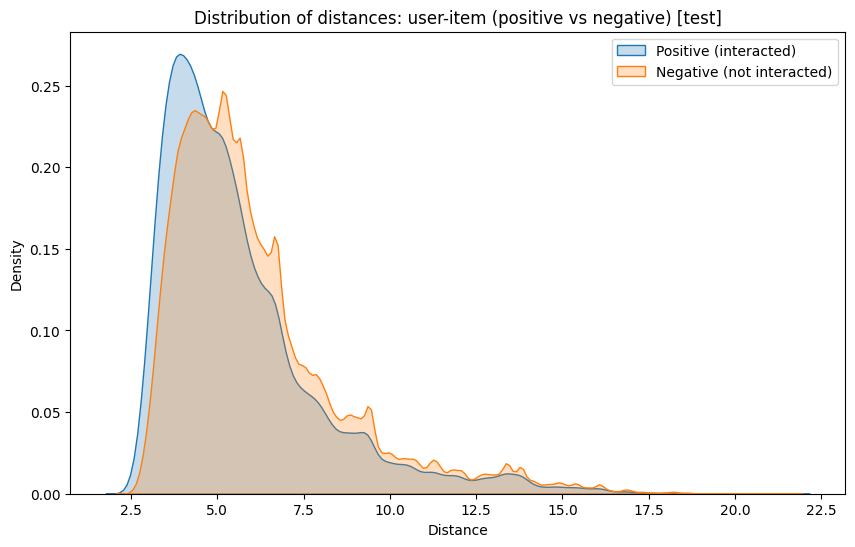
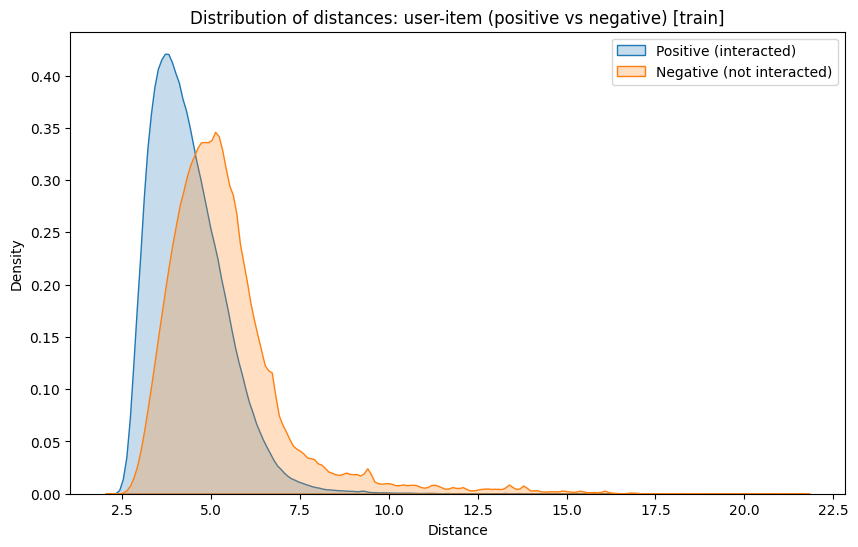

Триплет лосс, дропают, LN, 5 эпох:  
После добавления распределение расстояний на тренировочном и тестовом датасетах сместилось влево.  

Metrics on test set (all items):  
{'ndcg@10': 0.02362516138072357, 'map@10': 0.04165041467247998, 'novelty@10': 6.704579471536163}  
Metrics on test set (only new items):  
{'ndcg@10': 0.026416019038800274, 'map@10': 0.049272534531008376, 'novelty@10': 7.410556220576975}  
Metrics on train set:  
{'ndcg@10': 0.1590928053856303, 'map@10': 0.09365070823244875, 'novelty@10': 6.296392580539426}  

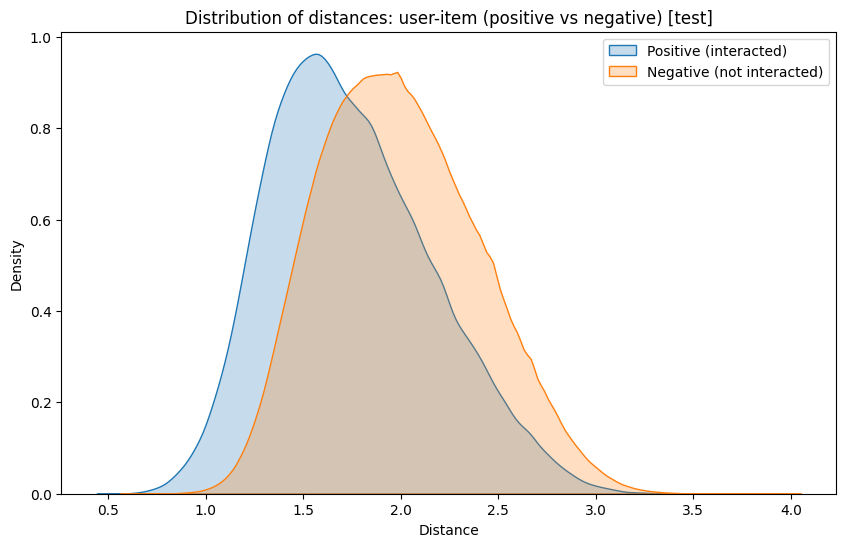
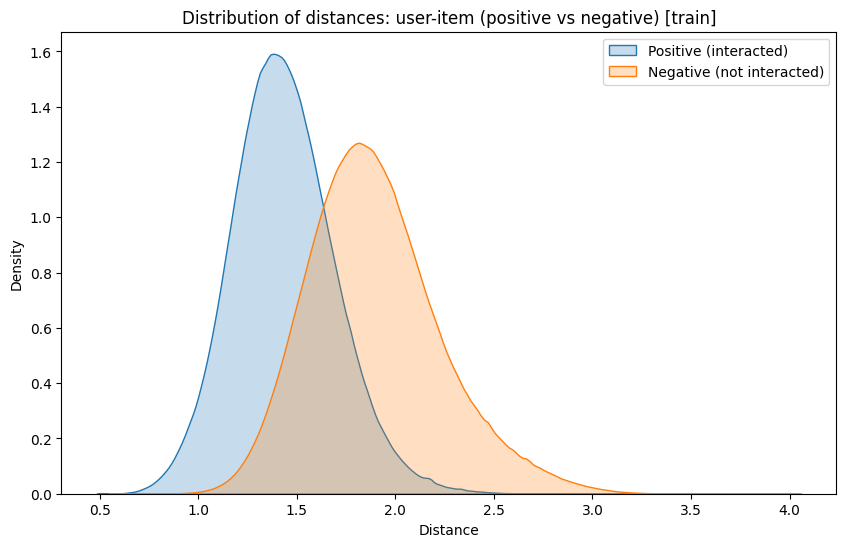

 
BPR_loss  
Metrics on test set (all items):  
{'ndcg@10': 0.00022799403808741964, 'map@10': 0.0002336042134449884, 'novelty@10': 11.537375548766876}  
Metrics on test set (only new items):  
{'ndcg@10': 0.00022876025679039637, 'map@10': 0.00023424274043325845, 'novelty@10': 11.541674360437256}  
Metrics on train set:  
{'ndcg@10': 0.0017234810371572673, 'map@10': 0.00032141210525153517, 'novelty@10': 11.554501635683124}  

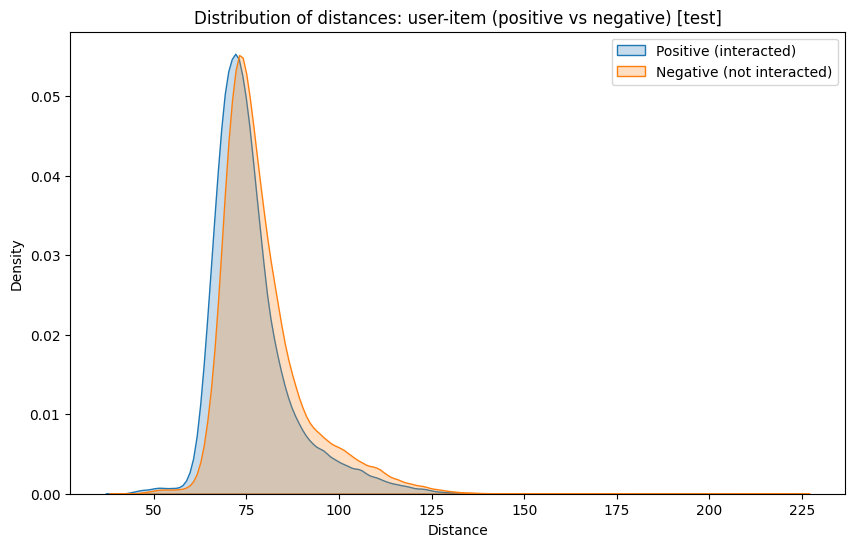
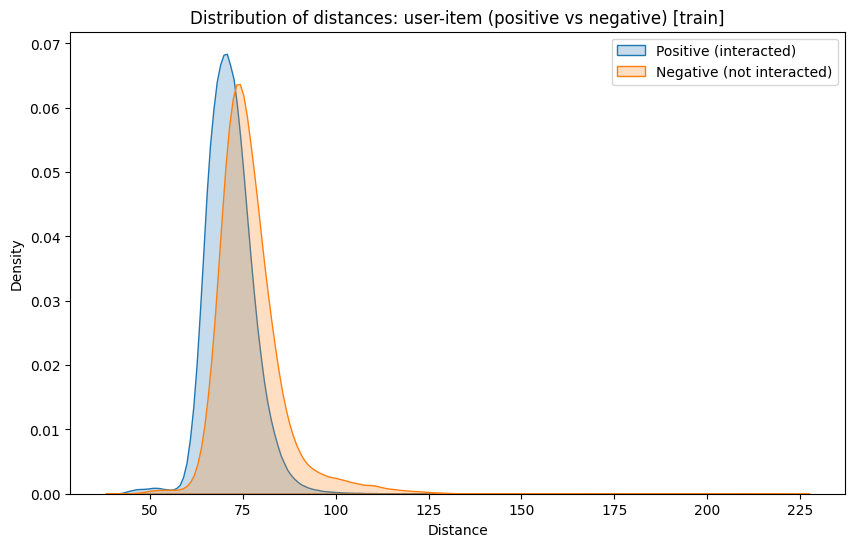

BPR_loss L2_norm  
Metrics on test set (all items):  
{'ndcg@10': 0.004268759723329381, 'map@10': 0.007981950890367883, 'novelty@10': 10.359371160120494}  
Metrics on test set (only new items):  
{'ndcg@10': 0.004424605129663591, 'map@10': 0.00840846146571718, 'novelty@10': 10.507040145281902}  
Metrics on train set:  
{'ndcg@10': 0.026595616391652716, 'map@10': 0.014998711478326257, 'novelty@10': 10.474641643549294}  

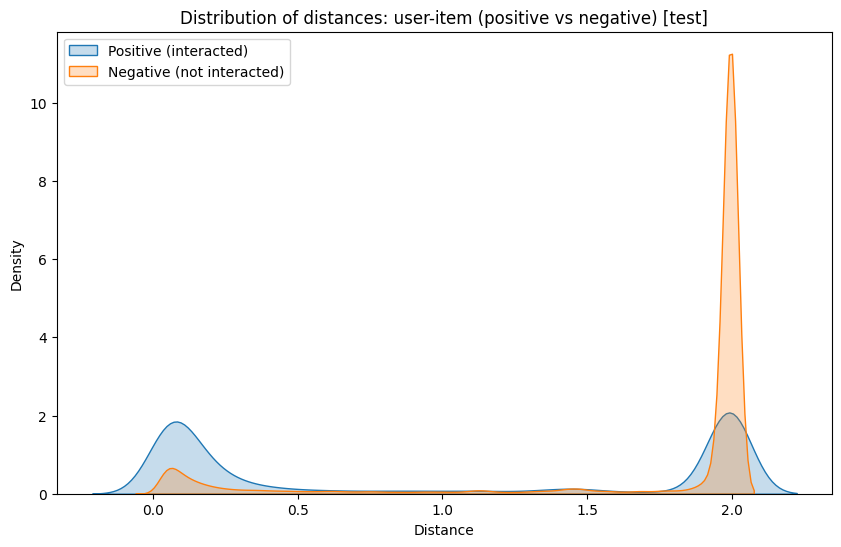
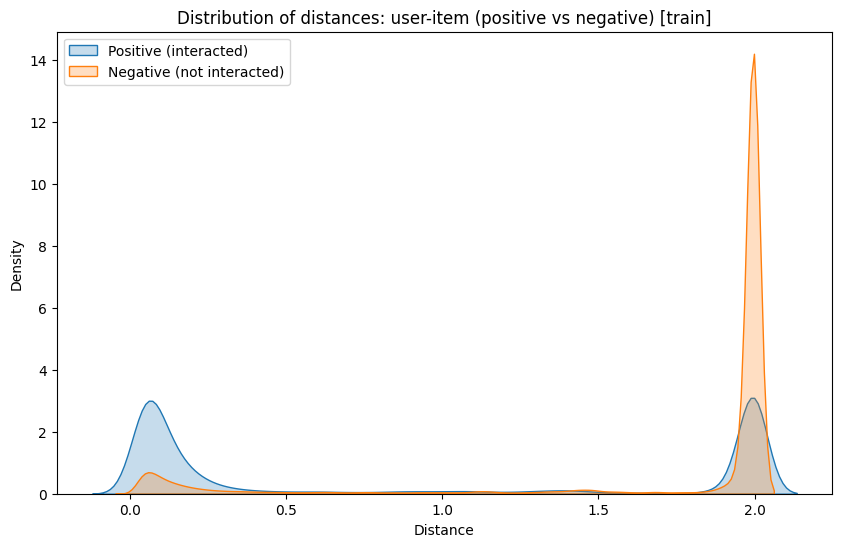

# 🧠 DSSM Homework: Improve the Model

Welcome! This assignment builds upon the DSSM model you studied during the seminar.

Your task is to **improve the DSSM model** by modifying the architecture, loss function, evaluation, or training pipeline. This is an open-ended assignment meant to encourage exploration.

In this seminar, you've explored a basic implementation of the Deep Structured Semantic Model (DSSM).

Your task is to **improve this model** in one or more of the following directions:

### ✅ Model Improvements
- Replace MLP towers with Transformer or RNN encoders or etc. (5 баллов)
- Use different triplet loss. (3 балла) 5 21:10
- Add dropout, batch normalization, or layer norm. (3 балла)
- Integrate embeddings instead of one-hot vectors. (5 баллов)
- Visualize similarity distribution for positive vs. negative pairs. (5 баллов)

### ✅ Evaluation & Analysis
- Visualize embeddings using t-SNE or UMAP. (3 баллов)
- Develop and improve beyond accuracy metrics. (5 баллов) 1:14

### 📄 Deliverables
- Explain what you changed and why in the final markdown cell. (3 балла)
- Keep code modular, clean, and well-documented. (3 балла)

### 📝 Production
- create service based on DSSM vectors with ANN. (8 баллов)

### 📝 Leaderboard
- Improve score from UserKNN via DSSM (8 баллов)


Максимум баллов, которые можно получить - 25.